In [1]:
from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle

In [2]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen


def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)

    return literal

In [22]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw'}
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self, child_state=None):
        """
        Returns the number of variables in the remaining clauses
        """
        if child_state is None:
            literal_clauseNum = self.state[0]
        else:
            literal_clauseNum = child_state[0]
        return sum(map(len, literal_clauseNum.values()))
    
#     def get_state(self, child_state=None):
#         """
#         Returns the number of variable to clause ratio in the remaining clauses
#         """
#         if child_state is None:
#             literal_clauseNum, clauseNum_clause, _ = self.state
#         else:
#             literal_clauseNum, clauseNum_clause, _ = child_state
        
# #         num_clauses = len(clauseNum_clause.keys())    # This gives correct value
# #         num_literals = len(literal_clauseNum.keys())  # We have some literals pointing to empty clauseNum set. Need to remove them.
        
#         clauses = set()
#         num_literals = 0 
#         for literal, clauseNum in literal_clauseNum.items():
#             if len(clauseNum) > 0:
#                 clauses = clauses.union(clauseNum)
#                 num_literals += 1
                
#         return 0 if num_literals == 0 else len(clauses) / num_literals
        
    
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
#         print("At start of step method")
#         print(literal_clauseNum)
#         print(literal_boolen)
        
        unassigned_nodes_start = len(list(filter(lambda x: len(x) > 0, literal_clauseNum.values())))
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After unit prop")
#         print(literal_clauseNum)
#         print(literal_boolen)
#         print()
        
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
            return 0, -1, isEmpty
        
        if clauseNum_clause == {}:
            return 0, 1, True
        
        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After literal elimination")
#         print(literal_clauseNum)
#         print(literal_boolen)
#         print()
            
        if clauseNum_clause == {}:
            return 0, 1, True
        
        literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=self.actions[action])
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
#         print("After setting", literal, "to True")
#         print(literal_clauseNum_T)
#         print(literal_boolen_T)
#         print()
        
#         unassigned_nodes_T = len(filter(lambda x: len(x) > 0, literal_clauseNum_T.values()))
        
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True
        
        # Add new state to queue
        
        self.stack.append((literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T))
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After setting", literal, "to False")
#         print(literal_clauseNum_F)
#         print(literal_boolen_F)
#         print()
            
#         unassigned_nodes_F = len(filter(lambda x: len(x) > 0, literal_clauseNum_F.values()))
            
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True

        # Add new state to queue
        
        self.state = (literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         other_child = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
#         return self.get_state(other_child), -1, False
    
        return None, -1, False
        
        # Using unassigned_nodes_start - unassigned_nodes_end as cost has been > 0 in testing

In [13]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        if epsilon > np.random.rand():
            return np.ones(nA) / nA
        else:
            action_value = Q[observation]
            action = np.argmax(action_value)
            ans = np.zeros(nA)
            ans[action] = 1
            return ans

    return policy_fn

In [38]:
def sarsa(filepaths, epochs, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0, alpha=0.5, resume=False):
    Q = np.zeros((300, actions))  # 91 clauses x 3 literals per clause gives a maximum of 273 different state values
    
    # Resuming training
    if resume:
        with open("Q_sarsa.pickle", 'rb') as fin:
            Q = pickle.load(fin)
            epsilon = 0.1
            epsilon_decay = 0.9999
            
            
    for epoch in range(epochs):
        print(epoch)
        
        for fileno, path in enumerate(filepaths):
#             if fileno % 100 == 0:
#                 print(fileno)
            
            policy = make_epsilon_greedy_policy(Q, epsilon*epsilon_decay, actions)
        
            env = Env(path)
            state = env.reset()
            action_prob = policy(state)
            action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
                
            while True:
                _, reward, done = env.step(action)
                if done:
                    td_target = reward
                    td_delta = td_target - Q[state][action]
                    alpha = 1.0
                    Q[state][action] += alpha * td_delta
                    break
                    
                next_state = env.get_state()
                # Pick the next action
                next_action_probs = policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                
                td_target = reward + discount_factor * Q[next_state][next_action]
                td_delta = td_target - Q[state][action]
                Q[state][action] += alpha * td_delta
                
                state = next_state
                action = next_action
                
            
            with open("Q_sarsa.pickle", 'wb') as fout:
                pickle.dump(Q, fout)
                
    return Q
    

    
def q_learning(filepaths, epochs, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0, alpha=0.5, resume=False):
    Q = np.zeros((300, actions))  # 91 clauses x 3 literals per clause gives a maximum of 273 different state values
    
    # Resuming training
    if resume:
        with open("Q_q.pickle", 'rb') as fin:
            Q  = pickle.load(fin)
            epsilon = 0.1
            epsilon_decay = 0.9999
            
    for epoch in range(epochs):
        print(epoch)
        
        for fileno, path in enumerate(filepaths):
#             if fileno % 100 == 0:
#                 print(fileno)
            
            policy = make_epsilon_greedy_policy(Q, epsilon*epsilon_decay, actions)
        
            env = Env(path)
            state = env.reset()
                
            while True:
                action_prob = policy(state)
                action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
                _, reward, done = env.step(action)
                if done:
                    td_target = reward
                    td_delta = td_target - Q[state][action]
                    alpha = 1.0
                    Q[state][action] += alpha * td_delta
                    break
                    
                next_state = env.get_state()    
                # TD Update
                best_next_action = np.argmax(Q[next_state])    
                td_target = reward + discount_factor * Q[next_state][best_next_action]
                td_delta = td_target - Q[state][action]
                alpha = 1.0
                Q[state][action] += alpha * td_delta
                
                state = next_state
                
            
            with open("Q_q.pickle", 'wb') as fout:
                pickle.dump(Q, fout)
                
    return Q

In [45]:
directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
filepaths = list(map(lambda x: os.path.join(directory, x), files))

actions = 4

Q = q_learning(filepaths, 10, epsilon=0.3, epsilon_decay=0.9999, alpha=0.6, resume=True)

print("Done")

0
1
2
3
4
5
6
7
8
9
Done


Text(0,0.5,'Action - between 0/1/2/3')

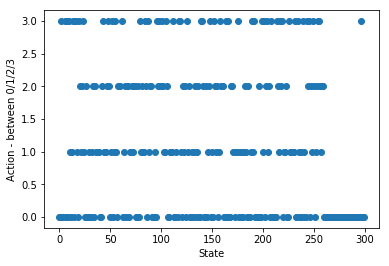

In [46]:
%matplotlib inline

policy = make_epsilon_greedy_policy(Q, epsilon=0.05, nA=actions)

# xs = np.linspace(0, 3, 300)
xs = range(300)
ys = [np.random.choice(np.arange(actions), p=policy(i)) for i in xs]
plt.scatter(xs, ys)
plt.xlabel("State")
plt.ylabel("Action - between 0/1/2/3")

In [47]:
state = 34
Q[state]

array([-5., -6., -9., -8.])

Text(0,0.5,'Q-value')

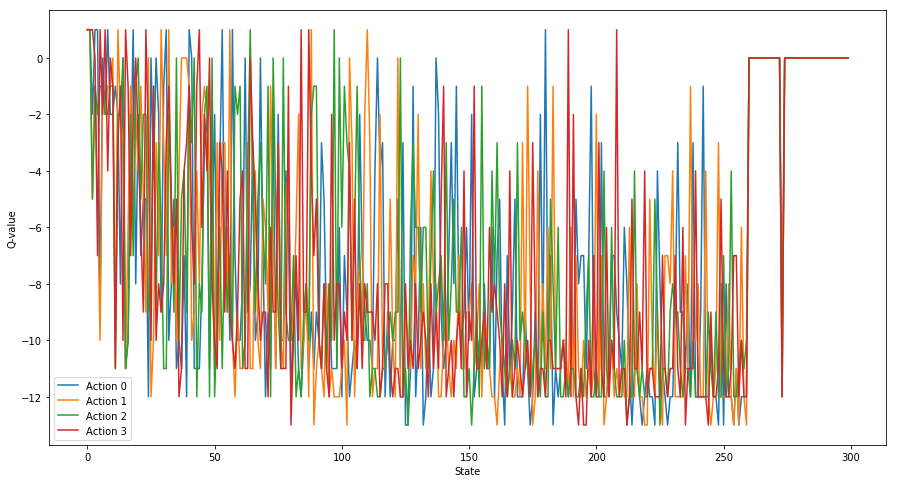

In [48]:
plt.figure(figsize=(15, 8))

q_values = np.array([Q[s] for s in xs])

for i in range(actions):
    plt.plot(xs, q_values[:, i], label='Action '+str(i))

plt.legend()
plt.xlabel('State')
plt.ylabel('Q-value')